In [27]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from matplotlib.pyplot import plot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

In [28]:

# Paths
train_dir = '/Users/rohansingh/Desktop/ComputerVision/LegDeformaties/train'
val_dir = '/Users/rohansingh/Desktop/ComputerVision/LegDeformaties/valid'
img_size =  224
batch_size = 32
epochs = 30

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,          # optional
    zoom_range=0.1,             # optional
    width_shift_range=0.1,      # optional
    height_shift_range=0.1,     # optional
    brightness_range=[0.7, 1.3] # approximate for saturation, but not exact
)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# === Model ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Initial training with frozen base
history = model.fit(
    train_generator,          # ✅ This is your actual training data
    validation_data=val_generator,
    epochs=epochs
)



# Fine-tuning
base_model.trainable = True
fine_tune_at = 140
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)
model.save('mobilenet_v1.h5')

Found 609 images belonging to 3 classes.
Found 52 images belonging to 3 classes.


/opt/anaconda3/envs/Deeplearning/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.4499 - loss: 1.8785 - val_accuracy: 0.5769 - val_loss: 1.1988
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.6746 - loss: 1.1086 - val_accuracy: 0.7308 - val_loss: 0.9885
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7351 - loss: 0.9016 - val_accuracy: 0.7500 - val_loss: 0.8489
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7705 - loss: 0.7352 - val_accuracy: 0.6731 - val_loss: 0.8786
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.7390 - loss: 0.8090 - val_accuracy: 0.7115 - val_loss: 0.7144
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7523 - loss: 0.8108 - val_accuracy: 0.7885 - val_loss: 0.5847
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.8057 - loss: 0.6216 - val_accuracy: 0.7692 - val_loss: 0.6318
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.8293 - loss: 0.5717 - val_accuracy: 0.

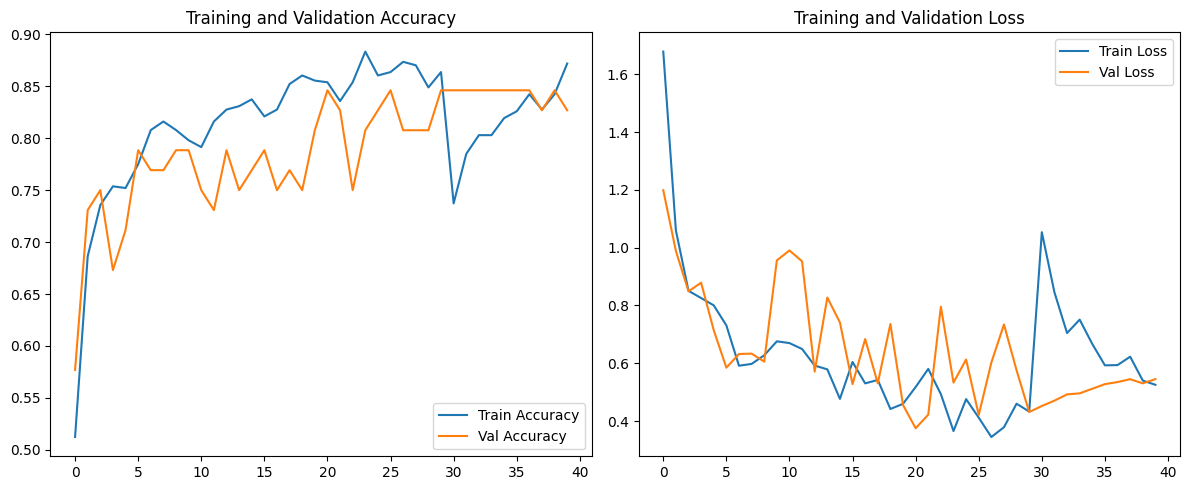

In [29]:
import matplotlib.pyplot as plt

# Combine both training histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [32]:
print(acc[-1])

0.871921181678772


In [33]:
# Class names (make sure order matches your training directory)
class_names = ['Bowlegs', 'Knock Knees', 'Normal Knee']  # Adjust if needed

In [34]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
    return img_array


In [35]:
img_path = "/Users/rohansingh/Desktop/ComputerVision/LegDeformaties/M2500039-Rickets.jpg"  # replace with actual path
img = preprocess_image(img_path)

pred = model.predict(img)[0]  # Get first batch result
for i, score in enumerate(pred):
    print(f"{class_names[i]}: {score:.2f}")

# Best prediction
best_index = np.argmax(pred)
print(f"\nPrediction: {class_names[best_index]} (Confidence: {pred[best_index]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Bowlegs: 0.95
Knock Knees: 0.05
Normal Knee: 0.00

Prediction: Bowlegs (Confidence: 0.95)
